# NLP - CA4 - Q1

* **Name:** Mohammada Mahdi Salmani
* **Student id:** 810102174

## Import libraries

In [ ]:
!pip install transformers datasets accelerate peft evaluate

In [ ]:
# !pip install accelerate -U
# !pip install transformers[torch]
# => (restart runtime)

In [ ]:
from datasets import load_dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EvalPrediction
import torch
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import evaluate

import warnings
warnings.simplefilter('ignore')

Exception ignored in: <function _xla_gc_callback at 0x7e013edec550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


## Load Multi-NLI dataset

In [ ]:
def load_subset_dataset(dataset_name, train_subset_ratio=0.08, val_subset_ratio=0.08):
    dataset = load_dataset(dataset_name)
    # print(f'Total dataset:\n{dataset}\n')
    # Reduce the dataset size:
    train_subset = dataset['train'].train_test_split(test_size = train_subset_ratio)
    validation_subset = dataset['validation_matched'].train_test_split(test_size=val_subset_ratio)

    subset_dataset = DatasetDict({
        'train': train_subset['test'],
        'validation': validation_subset['test']
    })
    print(f'Subset dataset:\n{subset_dataset}')
    return subset_dataset

In [ ]:
subset_dataset = load_subset_dataset("nyu-mll/multi_nli")

Subset dataset:
DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 31417
    })
    validation: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 786
    })
})


## Preprocess

In [ ]:
model_name = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length')

remove_columns = ['promptID', 'pairID', 'premise_binary_parse', 'premise_parse', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre']
encoded_dataset = subset_dataset.map(preprocess_function, batched=True, remove_columns=remove_columns)

Map:   0%|          | 0/31417 [00:00<?, ? examples/s]

Map:   0%|          | 0/786 [00:00<?, ? examples/s]

In [ ]:
class_names = encoded_dataset["train"].features["label"].names
print(f"Labels: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'input_ids', 'attention_mask'],
        num_rows: 31417
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'input_ids', 'attention_mask'],
        num_rows: 786
    })
})

## Load RoBERTa-Large model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(class_names), id2label=id2label, label2id=label2id)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

## Full fine-tuning

### Intialize trainer

In [ ]:
batch_size = 8
learning_rate = 2e-5
num_train_epochs = 2

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    max_steps=5000,
    evaluation_strategy="steps",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_steps=500,
    save_total_limit=2,
    eval_steps=250,
    logging_dir='./logs',
    logging_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    weight_decay=0.01,
    fp16=True,
)

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


### Train

* First try

In [ ]:
train_result = trainer.train()

Step,Training Loss,Validation Loss
250,1.109700,1.099332
500,1.132200,1.106368
750,1.115900,1.101610
1000,1.109800,1.104065
1250,1.104600,1.100580
1500,1.102200,1.099197
1750,1.103100,1.100600
2000,1.111000,1.104008
2250,1.111100,1.099096
2500,1.107000,1.099058


* Second try

In [ ]:
train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
250,1.129100,1.103258,0.290076
500,1.113800,1.097898,0.384224
750,1.111900,1.101082,0.384224
1000,1.108900,1.117553,0.290076
1250,1.105500,1.095461,0.384224
1500,1.106900,1.108900,0.290076
1750,1.109500,1.099307,0.290076
2000,1.106000,1.105768,0.290076
2250,1.111600,1.098289,0.384224
2500,1.101200,1.099120,0.325700


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save
# trainer.save_model("/content/drive/MyDrive/RoBERTa")
tokenizer.save_pretrained('modified_base')
model.save_pretrained('full_ft_model')

# !cp -r /content/full_ft_model /content/drive/MyDrive/NLP/RoBERTa
# !cp -r /content/modified_base /content/drive/MyDrive/NLP/RoBERTa

### Plot results

In [ ]:
log_history = trainer.state.log_history

* First try results:

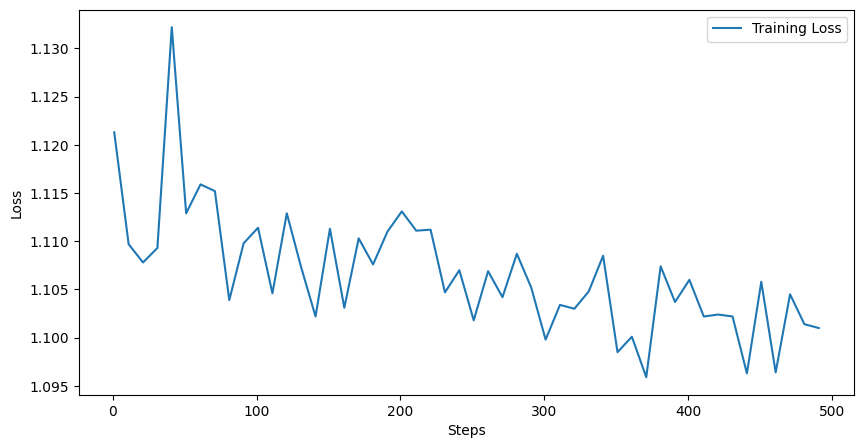

In [ ]:
train_loss = [log['loss'] for log in log_history if 'loss' in log]
# eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
steps = range(1,1+len(train_loss)*10,10)

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

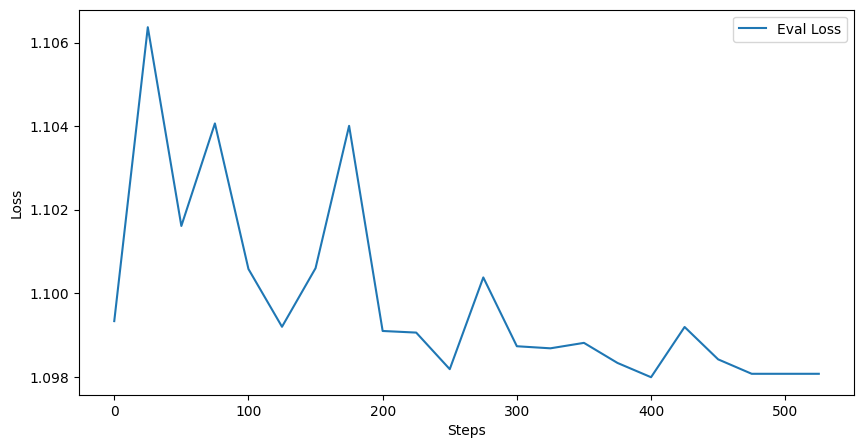

In [ ]:
# train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
steps = range(0,len(eval_loss)*25,25)

plt.figure(figsize=(10, 5))
plt.plot(steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

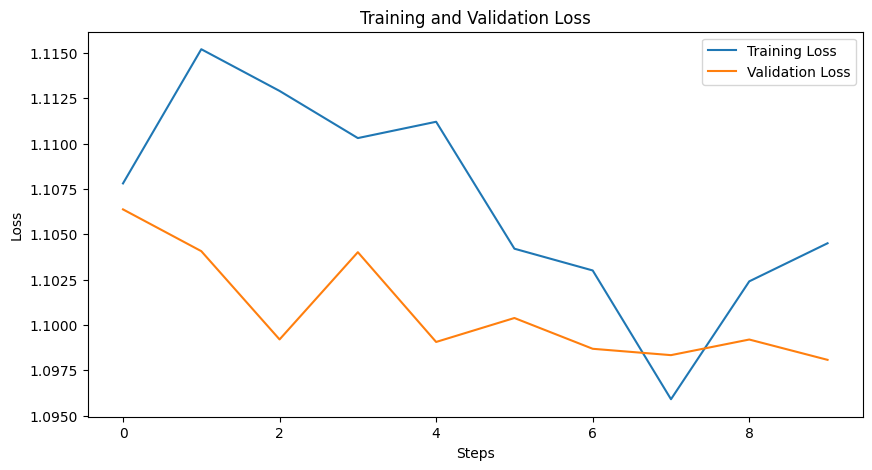

In [ ]:
train_loss = [log['loss'] for log in log_history[3::7]]
eval_loss = [log['eval_loss'] for log in log_history[6::7]]
steps = range(len(train_loss))

plot_losses(steps, train_loss, eval_loss)

* Second try results:

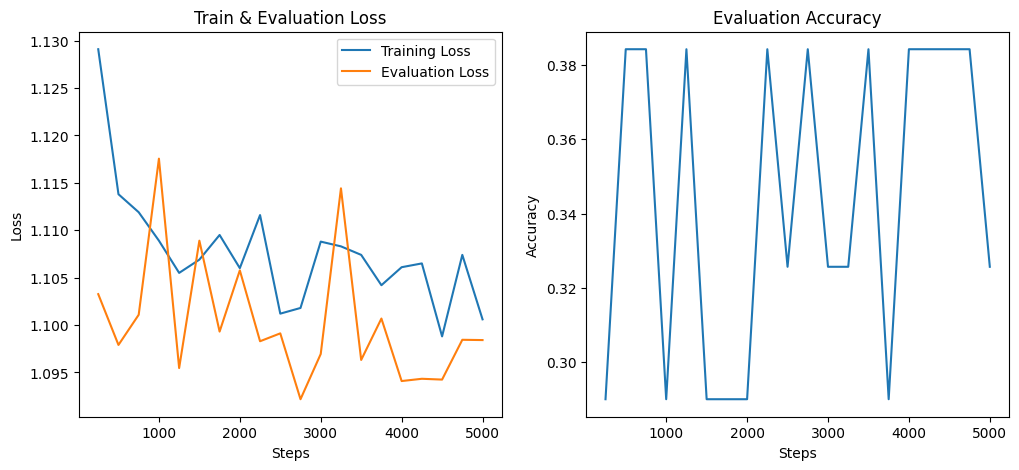

In [ ]:
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
steps = range(250,5001,250)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train & Evaluation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, label="Eval Acc")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.show()

### Evaluate

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 1.0980712175369263,
 'eval_runtime': 26.8345,
 'eval_samples_per_second': 29.291,
 'eval_steps_per_second': 3.689,
 'epoch': 1.2729124236252547}

In [ ]:
from datasets import load_metric

accuracy_metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

eval_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics
)

eval_results = eval_trainer.evaluate()

In [ ]:
print(f"Validation Accuracy: {eval_results}")

Validation Accuracy: {'eval_loss': 1.0980712175369263, 'eval_accuracy': 0.3473282442748092, 'eval_runtime': 29.1407, 'eval_samples_per_second': 26.973, 'eval_steps_per_second': 3.397}


## LoRA fine-tuning

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]
)

peft_model = get_peft_model(model, lora_config)

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 1,642,499 || all params: 357,005,318 || trainable%: 0.4601


In [ ]:
learning_rate = 3e-5
batch_size = 8
num_train_epochs = 2

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    max_steps=5000,
    evaluation_strategy="steps",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_steps=500,
    save_total_limit=2,
    eval_steps=250,
    logging_dir='./logs',
    logging_steps=250,
    load_best_model_at_end=True,
    weight_decay=0.01,
    fp16=True,
)

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
250,1.109000,1.101659,0.354962
500,1.110000,1.096951,0.342239
750,1.103900,1.096614,0.330789
1000,1.099600,1.086550,0.438931
1250,1.030100,0.880937,0.634860
1500,0.828300,0.637030,0.745547
1750,0.694700,0.580439,0.776081
2000,0.657800,0.545296,0.791349
2250,0.605900,0.560956,0.790076
2500,0.578100,0.525876,0.801527


In [ ]:
# Save
# trainer.save_model("/content/drive/MyDrive/RoBERTa")
tokenizer.save_pretrained('modified_base')
model.save_pretrained('peft_model')

!cp -r /content/peft_model /content/drive/MyDrive/NLP/RoBERTa
!cp -r /content/modified_base /content/drive/MyDrive/RoBERTa

In [ ]:
def plot_losses(steps, train_loss, eval_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(eval_loss, label="Validation Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

In [ ]:
log_history = trainer.state.log_history
log_history

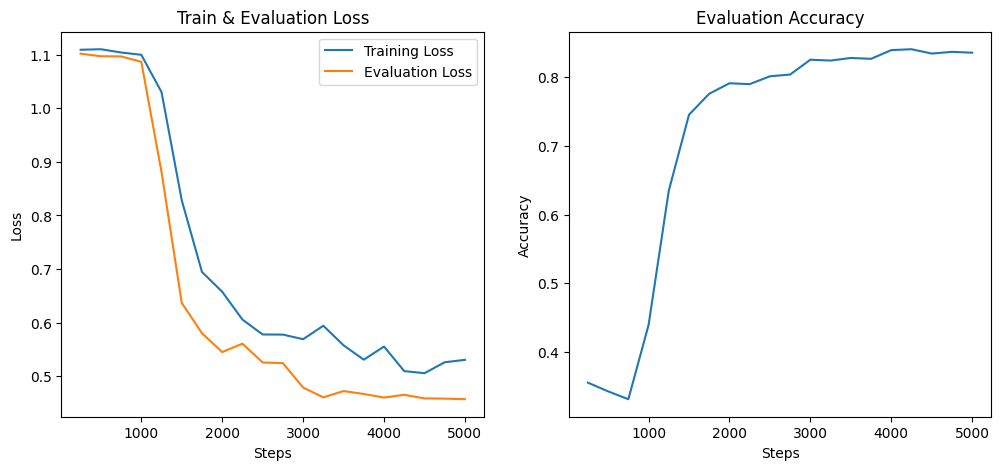

In [ ]:
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
steps = range(250,5001,250)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train & Evaluation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, label="Eval Acc")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.show()

In [ ]:
log_history[-2]

{'eval_loss': 0.45738643407821655,
 'eval_accuracy': 0.8358778625954199,
 'eval_runtime': 29.8338,
 'eval_samples_per_second': 26.346,
 'eval_steps_per_second': 3.318,
 'epoch': 1.2729124236252547,
 'step': 5000}

In [ ]:
print("Train metrics:\n")
train_result.metrics

Train metrics:



{'train_runtime': 4616.9128,
 'train_samples_per_second': 8.664,
 'train_steps_per_second': 1.083,
 'total_flos': 3.747265190035661e+16,
 'train_loss': 0.7138264022827149,
 'epoch': 1.2729124236252547}

## P-Tuning

In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,
        padding='max_length',
        max_length=480,
    )

remove_columns = ['promptID', 'pairID', 'premise_binary_parse', 'premise_parse', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre']
encoded_dataset = subset_dataset.map(preprocess_function, batched=True, remove_columns=remove_columns)

Map:   0%|          | 0/31417 [00:00<?, ? examples/s]

Map:   0%|          | 0/786 [00:00<?, ? examples/s]

In [ ]:
from peft import PromptEncoder, PromptEncoderConfig

prompt_config = PromptEncoderConfig(
    peft_type="P_TUNING",
    task_type=TaskType.SEQ_CLS,
    num_virtual_tokens=30,
    token_dim=1024,
    num_transformer_submodules=1,
    num_attention_heads=16,
    num_layers=24,
    encoder_reparameterization_type="MLP",
    encoder_hidden_size=1024,
)

peft_model = get_peft_model(model, prompt_config)

In [8]:
peft_model.print_trainable_parameters()

trainable params: 4,232,195 || all params: 359,595,014 || trainable%: 1.1769


In [2]:
# def preprocess_function(examples):
#     template = "Premise: {premise} Hypothesis: {hypothesis}"
#     inputs = tokenizer([template.format(premise=p, hypothesis=h) for p, h in zip(examples['premise'], examples['hypothesis'])],
#                        truncation=True, padding='max_length')
#     inputs["labels"] = examples["label"]
#     return inputs

# encoded_subset_dataset = subset_dataset.map(preprocess_function, batched=True, remove_columns=subset_dataset["train"].column_names)
# encoded_subset_dataset

In [ ]:
learning_rate = 5e-5
batch_size = 8
num_train_epochs = 2

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=num_train_epochs,
    max_steps=5000,
    evaluation_strategy="steps",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_steps=500,
    save_total_limit=2,
    eval_steps=250,
    logging_dir='./logs',
    logging_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    weight_decay=0.01,
    fp16=True,
)

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=p.label_ids)

In [ ]:
from transformers import default_data_collator

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


* First try

In [ ]:
train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
250,1.125400,1.099251,0.365140
500,1.120200,1.110465,0.307888
750,1.119100,1.104585,0.307888
1000,1.112200,1.110886,0.307888
1250,1.115800,1.098282,0.365140
1500,1.107900,1.096391,0.365140
1750,1.113300,1.097667,0.365140
2000,1.106700,1.099567,0.365140
2250,1.109700,1.097746,0.365140
2500,1.112500,1.097894,0.365140


KeyboardInterrupt: 

* Second try

In [ ]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
250,1.115400,1.146689,0.323155
500,1.114300,1.112066,0.326972
750,1.116000,1.094717,0.367684
1000,1.110500,1.101602,0.346056
1250,1.113100,1.101229,0.332061
1500,1.120100,1.102806,0.342239
1750,1.107500,1.100357,0.309160
2000,1.107000,1.107083,0.346056
2250,1.110300,1.105623,0.330789
2500,1.105300,1.102707,0.315522


In [ ]:
tokenizer.save_pretrained('p_tuning_modified_base')
model.save_pretrained('p_tuning_model')

In [ ]:
!cp -r /content/p_tuning_modified_base  /content/drive/MyDrive/NLP/RoBERTa
!cp -r /content/p_tuning_model  /content/drive/MyDrive/NLP/RoBERTa

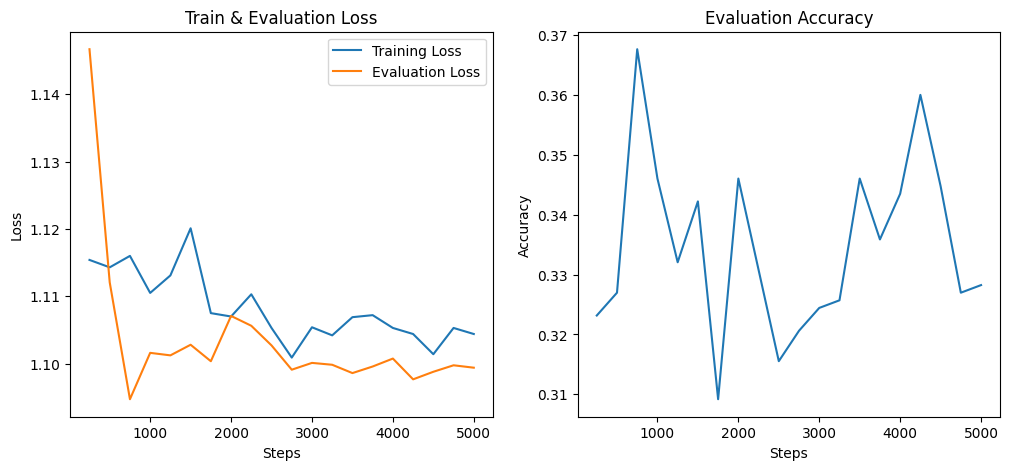

In [ ]:
log_history = trainer.state.log_history

train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
steps = range(250,5001,250)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps, eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train & Evaluation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, label="Eval Acc")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.show()

In [ ]:
log_history[-1]

{'eval_loss': 1.099398136138916,
 'eval_accuracy': 0.3282442748091603,
 'eval_runtime': 30.1047,
 'eval_samples_per_second': 26.109,
 'eval_steps_per_second': 3.289,
 'epoch': 1.2729124236252547,
 'step': 5000}

In [ ]:
train_results

{'eval_loss': 1.099398136138916, 'eval_accuracy': 0.3282442748091603}